In [ ]:
!pip install pytorch_lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.9/801.9 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 23.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-man

In [ ]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/MyDrive/BT5151 Grp Proj!'
    print(path_to_file)
    # move to Google Drive directory
    os.chdir(path_to_file)
    !pwd

Mounted at /content/gdrive
/content/gdrive/MyDrive/BT5151 Grp Proj!
/content/gdrive/.shortcut-targets-by-id/1labx7YQZuN5vcXgIX4tcowPIRSJ2C_Db/BT5151 Grp Proj!


In [ ]:
import torch
print("Is CUDA available: ", torch.cuda.is_available())
print("Num GPUs Available: ", torch.cuda.device_count())

Is CUDA available:  True
Num GPUs Available:  1


In [ ]:
import torch
from torch import nn
from torch.optim import AdamW
from torchvision import transforms, datasets, models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split, Subset
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torchmetrics import Accuracy
import torch.nn.functional as F
from torch.autograd import Variable

# Hybrid

In [ ]:
# resnet50 TODO
class HybridCNNTransformer(pl.LightningModule):
    def __init__(self, num_classes=20, learning_rate=1e-3):
        super().__init__()
        self.learning_rate = learning_rate
        self.accuracy = Accuracy(num_classes=num_classes, average='macro', task='multiclass')
        self.cnn = models.resnet50(pretrained=True)  # Using ResNet18 as the CNN
        self.cnn.fc = nn.Identity()
        self.transformer = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=2048, nhead=8), num_layers=1)
        self.classifier = nn.Linear(2048, num_classes)  # Adjust input dim to 2048 for ResNet50
        self.criterion = nn.CrossEntropyLoss()

        for param in self.cnn.parameters():
          param.requires_grad = False  # Freeze all parameters in the ResNet
        for param in self.transformer.parameters():
          param.requires_grad = False  # Freeze all parameters in the ResNet

    def forward(self, x):
        cnn_features = self.cnn(x).unsqueeze(1)  # Add sequence dimension
        transformer_output = self.transformer(cnn_features).squeeze(1)
        logits = self.classifier(transformer_output)
        return logits

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        self.log('train_loss', loss)
        self.log('train_acc', self.accuracy(logits, y), prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', self.accuracy(logits, y), prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        self.log('test_loss', loss)
        self.log('test_acc', self.accuracy(logits, y))

    def configure_optimizers(self):
        return AdamW(self.parameters(), lr=self.learning_rate)

In [ ]:
# # resnet50 double transformer
# class HybridCNNTransformer(pl.LightningModule):
#     def __init__(self, num_classes=20, learning_rate=1e-3):
#         super().__init__()
#         self.learning_rate = learning_rate
#         self.accuracy = Accuracy(num_classes=num_classes, average='macro', task='multiclass')
#         self.cnn = models.resnet50(pretrained=True)  # Using ResNet18 as the CNN
#         self.cnn.fc = nn.Identity()
#         # self.cnn.fc = nn.Linear(2048, 512)
#         self.transformer = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=2048, nhead=8), num_layers=1)
#         self.shrink = nn.Linear(2048, 512)
#         self.transformer2 = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=512, nhead=8), num_layers=1)
#         self.classifier = nn.Linear(512, num_classes)  # Adjust input dim to 2048 for ResNet50
#         self.criterion = nn.CrossEntropyLoss()

#         for param in self.cnn.parameters():
#           param.requires_grad = False  # Freeze all parameters in the ResNet
#         for param in self.transformer.parameters():
#           param.requires_grad = False  # Freeze all parameters in the ResNet
#         for param in self.transformer2.parameters():
#           param.requires_grad = False  # Freeze all parameters in the ResNet

#     def forward(self, x):
#         cnn_features = self.cnn(x).unsqueeze(1)  # Add sequence dimension
#         transformer_output = self.transformer(cnn_features).squeeze(1)
#         transformer_output2 = self.transformer2(self.shrink(transformer_output).squeeze(1)).squeeze(1)
#         logits = self.classifier(transformer_output2)
#         return logits

#     def training_step(self, batch, batch_idx):
#         x, y = batch
#         logits = self(x)
#         loss = self.criterion(logits, y)
#         self.log('train_loss', loss)
#         self.log('train_acc', self.accuracy(logits, y), prog_bar=True)
#         return loss

#     def validation_step(self, batch, batch_idx):
#         x, y = batch
#         logits = self(x)
#         loss = self.criterion(logits, y)
#         self.log('val_loss', loss, prog_bar=True)
#         self.log('val_acc', self.accuracy(logits, y), prog_bar=True)

#     def test_step(self, batch, batch_idx):
#         x, y = batch
#         logits = self(x)
#         loss = self.criterion(logits, y)
#         self.log('test_loss', loss)
#         self.log('test_acc', self.accuracy(logits, y))

#     def configure_optimizers(self):
#         return AdamW(self.parameters(), lr=self.learning_rate)

In [ ]:
# # resnet18 TODO
# class HybridCNNTransformer(pl.LightningModule):
#     def __init__(self, num_classes=20, learning_rate=1e-3):
#         super().__init__()
#         self.learning_rate = learning_rate
#         self.accuracy = Accuracy(num_classes=num_classes, average='macro', task='multiclass')
#         self.cnn = models.resnet18(pretrained=True)  # Using ResNet18 as the CNN
#         self.cnn.fc = nn.Identity()  # Remove the final FC layer
#         self.transformer = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=512, nhead=8), num_layers=1)
#         self.classifier = nn.Linear(512, num_classes)
#         self.criterion = nn.CrossEntropyLoss()

#         for param in self.cnn.parameters():
#           param.requires_grad = False  # Freeze all parameters in the ResNet
#         for param in self.transformer.parameters():
#           param.requires_grad = False  # Freeze all parameters in the ResNet

#     def forward(self, x):
#         cnn_features = self.cnn(x).unsqueeze(1)  # Add sequence dimension
#         transformer_output = self.transformer(cnn_features).squeeze(1)
#         logits = self.classifier(transformer_output)
#         return logits

#     def training_step(self, batch, batch_idx):
#         x, y = batch
#         logits = self(x)
#         loss = self.criterion(logits, y)
#         self.log('train_loss', loss)
#         self.log('train_acc', self.accuracy(logits, y), prog_bar=True)
#         return loss

#     def validation_step(self, batch, batch_idx):
#         x, y = batch
#         logits = self(x)
#         loss = self.criterion(logits, y)
#         self.log('val_loss', loss, prog_bar=True)
#         self.log('val_acc', self.accuracy(logits, y), prog_bar=True)

#     def test_step(self, batch, batch_idx):
#         x, y = batch
#         logits = self(x)
#         loss = self.criterion(logits, y)
#         self.log('test_loss', loss)
#         self.log('test_acc', self.accuracy(logits, y))

#     def configure_optimizers(self):
#         return AdamW(self.parameters(), lr=self.learning_rate)

### CNN architecture

In [ ]:
# # def mish(input):
# #     return input * torch.tanh(F.softplus(input))

# class CustomCNN(pl.LightningModule):
#     def __init__(self, num_classes=20, learning_rate=1e-3):
#         super().__init__()
#         self.learning_rate = learning_rate
#         self.accuracy = Accuracy(num_classes=num_classes, average='macro', task='multiclass')
#         self.model = nn.Sequential(
#             nn.Conv2d(3, 32, kernel_size=3, padding=1),
#             nn.BatchNorm2d(32),
#             # mish,
#             nn.MaxPool2d(2, 2),
#             nn.Conv2d(32, 64, kernel_size=3, padding=1),
#             nn.BatchNorm2d(64),
#             # mish,
#             nn.MaxPool2d(2, 2),
#             nn.Conv2d(64, 128, kernel_size=3, padding=1),
#             nn.BatchNorm2d(128),
#             # mish,
#             nn.MaxPool2d(2, 2),
#             nn.Dropout(0.5),
#             nn.Conv2d(128, 256, kernel_size=3, padding=1),
#             nn.BatchNorm2d(256),
#             # mish,
#             nn.AdaptiveAvgPool2d((1, 1)),
#             nn.Flatten(),
#             nn.Dropout(0.5),
#             nn.Linear(256, num_classes)
#         )
#         self.criterion = nn.CrossEntropyLoss()

#     def forward(self, x):
#         return self.model(x)

#     def training_step(self, batch, batch_idx):
#         x, y = batch
#         logits = self(x)
#         loss = self.criterion(logits, y)
#         self.log('train_loss', loss)
#         self.log('train_acc', self.accuracy(logits, y), prog_bar=True)
#         return loss

#     def validation_step(self, batch, batch_idx):
#         x, y = batch
#         logits = self(x)
#         loss = self.criterion(logits, y)
#         self.log('val_loss', loss, prog_bar=True)
#         self.log('val_acc', self.accuracy(logits, y), prog_bar=True)

#     def test_step(self, batch, batch_idx):
#         x, y = batch
#         logits = self(x)
#         loss = self.criterion(logits, y)
#         self.log('test_loss', loss)
#         self.log('test_acc', self.accuracy(logits, y))

#     def configure_optimizers(self):
#         return AdamW(self.parameters(), lr=self.learning_rate)

# Defining data loaders

In [ ]:
# Define transformations
common_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a standard size
    # transforms.RandomHorizontalFlip(),  # Apply random horizontal flip
    # transforms.RandomRotation(10),  # Random rotation
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Color jitter for augmentation
    # transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Random affine transformations
    transforms.ToTensor(),  # Convert images to tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize images
])

# Load the dataset with applied transformations
full_dataset = ImageFolder('foods', transform=common_transforms)

In [ ]:
len(full_dataset)

18014

In [ ]:
# Define dataset split sizes as proportions (0 to 1)
train_prop = 0.7
val_prop = 0.15
test_prop = 1 - train_prop - val_prop  # Ensure all data is used

# Calculate actual sizes based on full dataset length
full_dataset_len = len(full_dataset)  # Assuming you know the length of full_dataset
train_size = int(train_prop * full_dataset_len)
val_size = int(val_prop * full_dataset_len)
test_size = full_dataset_len - train_size - val_size  # Might be redundant but ensures all data

train_dataset_full, val_dataset_full, test_dataset_full = random_split(full_dataset, [train_size, val_size, test_size])

In [ ]:
# subsampling for faster training
subsample_ratio = 0.1  # Subsample 50% of the training data

train_dataset, _ = random_split(train_dataset_full, [subsample_ratio, 1-subsample_ratio])
val_dataset, _ = random_split(val_dataset_full, [subsample_ratio, 1-subsample_ratio])
test_dataset, _ = random_split(test_dataset_full, [subsample_ratio, 1-subsample_ratio])

len(train_dataset), len(val_dataset), len(test_dataset)

(1261, 271, 271)

In [ ]:
# Set up DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
# Check DataLoader lengths and shapes of data
print("Number of training batches:", len(train_loader))
print("Number of validation batches:", len(val_loader))
print("Number of test batches:", len(test_loader))

# Grab a single batch from each DataLoader
train_images, train_labels = next(iter(train_loader))
val_images, val_labels = next(iter(val_loader))
test_images, test_labels = next(iter(test_loader))

# Check the shape of the images and labels
print("Shape of train images:", train_images.shape)  # Expect [batch_size, 3, 224, 224]
print("Shape of train labels:", train_labels.shape)  # Expect [batch_size]

print("Shape of validation images:", val_images.shape)
print("Shape of validation labels:", val_labels.shape)

print("Shape of test images:", test_images.shape)
print("Shape of test labels:", test_labels.shape)

Number of training batches: 40
Number of validation batches: 9
Number of test batches: 9
Shape of train images: torch.Size([32, 3, 224, 224])
Shape of train labels: torch.Size([32])
Shape of validation images: torch.Size([32, 3, 224, 224])
Shape of validation labels: torch.Size([32])
Shape of test images: torch.Size([32, 3, 224, 224])
Shape of test labels: torch.Size([32])


In [ ]:
# Check label distribution in a batch
label_counts = torch.unique(train_labels, return_counts=True)
print("Label counts in a batch:", dict(zip(label_counts[0].tolist(), label_counts[1].tolist())))

Label counts in a batch: {0: 2, 1: 1, 3: 2, 4: 1, 5: 2, 6: 1, 7: 4, 8: 2, 9: 1, 11: 1, 12: 1, 13: 2, 15: 1, 16: 1, 17: 4, 18: 1, 19: 5}


## Visualizing sample

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img.numpy().transpose((1, 2, 0))  # Convert from Tensor image
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean  # Unnormalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.show()

# Get a batch of training data
images, labels = next(iter(train_loader))

In [ ]:
mapping = full_dataset.class_to_idx

print(mapping)

{'ban_mian': 0, 'chai_tow_kway': 1, 'char_kway_teow': 2, 'char_siew_rice': 3, 'chicken_masala': 4, 'chicken_rice': 5, 'curry_puff': 6, 'goreng_pisang': 7, 'hokkien_prawn_mee': 8, 'kway_chap': 9, 'laksa': 10, 'lotong_w_sayur_lodeh': 11, 'mee_rebus': 12, 'nasi_lemak': 13, 'rojak': 14, 'roti_john': 15, 'roti_prata': 16, 'satay': 17, 'siew_mai': 18, 'spring_roll': 19}


In [ ]:
def invert_dict(my_dict):
  """
  Inverts a dictionary, creating a new dictionary where possible.

  Args:
      my_dict: The dictionary to invert.

  Returns:
      A new dictionary with values as keys and keys as values (if possible),
      or None if a key appears multiple times.
  """
  inverted_dict = {}
  for key, value in my_dict.items():
    if value in inverted_dict:
      # If the value already exists as a key, inversion isn't possible (multiple keys map to the same value)
      return None
    inverted_dict[value] = key
  return inverted_dict

inverted_mapping = invert_dict(mapping.copy())
print(inverted_mapping)

{0: 'ban_mian', 1: 'chai_tow_kway', 2: 'char_kway_teow', 3: 'char_siew_rice', 4: 'chicken_masala', 5: 'chicken_rice', 6: 'curry_puff', 7: 'goreng_pisang', 8: 'hokkien_prawn_mee', 9: 'kway_chap', 10: 'laksa', 11: 'lotong_w_sayur_lodeh', 12: 'mee_rebus', 13: 'nasi_lemak', 14: 'rojak', 15: 'roti_john', 16: 'roti_prata', 17: 'satay', 18: 'siew_mai', 19: 'spring_roll'}


In [ ]:
size = len(labels)

# Plot the images in the batch, along with the corresponding labels
for idx in range(size):
    # ax = fig.add_subplot(2, 4, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    label_idx = labels[idx].item()
    plt.title(f"Label: {inverted_mapping[label_idx], label_idx}")

Output hidden; open in https://colab.research.google.com to view.

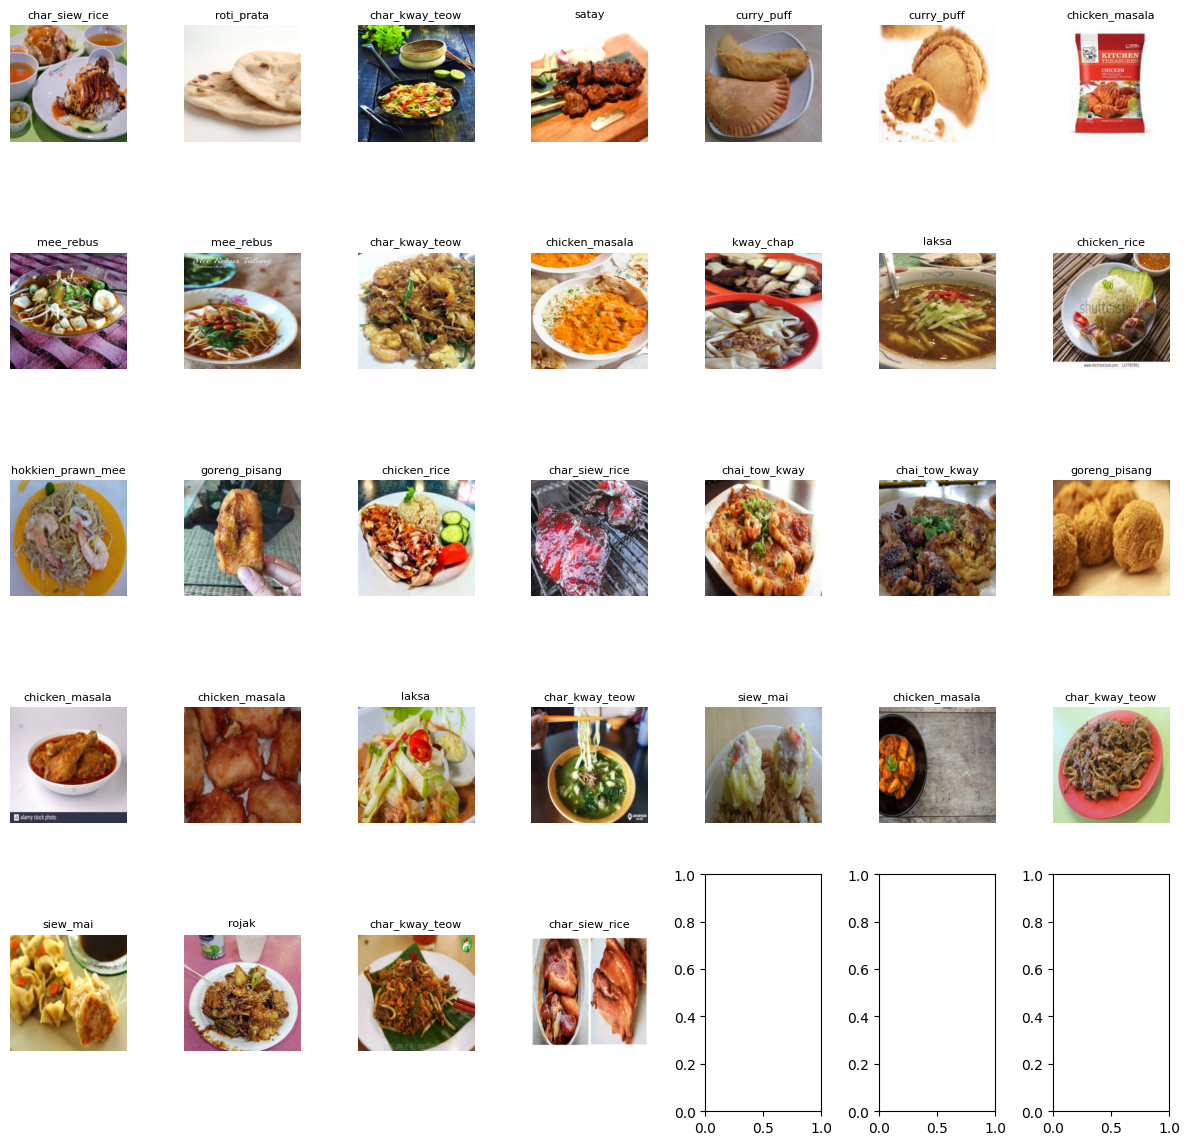

In [ ]:
 # Calculate the grid dimensions based on the number of images (adjust as needed)
num_images = len(labels)
rows = int(np.sqrt(num_images))  # Assuming a square grid (adjust if necessary)
cols = int(np.ceil(num_images / rows))

# Create a figure and subplots for the grid layout
fig, axes = plt.subplots(rows, cols, figsize=(12, 12))  # Adjust figure size as needed

# Flatten the axes if the number of images is not a perfect square
axes = axes.ravel() if num_images != rows * cols else axes

# Plot each image and label in its corresponding subplot
for idx, (image, label) in enumerate(zip(images, labels)):
    ax = axes[idx]
    img = image.numpy().transpose((1, 2, 0))  # Convert from Tensor image
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean  # Unnormalize
    img = np.clip(img, 0, 1)
    # plt.imshow(img)
    ax.imshow(img)

    ax.axis('off')  # Hide axes for cleaner presentation
    label_idx = label.item()
    ax.set_title(f"{inverted_mapping[label_idx]}", fontsize=8)  # Adjust font size


# Adjust spacing between subplots for better readability
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.tight_layout()

# Display the grid of images and labels
plt.show()

### Validating all food labels

In [ ]:
# # Check the class to index mapping
# print(full_dataset.class_to_idx)

# # Get all labels from the dataset
# all_labels = [label for _, label in full_dataset]

# # Count each label
# from collections import Counter
# label_counts = Counter(all_labels)
# print(label_counts)

# Model train n test

In [ ]:
# Define the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints/",  # Directory where the checkpoints will be saved
    filename="best-checkpoint-{epoch:02d}-{val_loss:.2f}",
    save_top_k=1,  # Save only the best checkpoint
    verbose=True,
    monitor="val_acc",  # Metric to monitor (validation accuracy)
    mode="max",  # Maximize the monitored metric (val_acc)
    # monitor="val_loss",  # Metric to monitor
    # mode="min",  # Minimize the monitored metric (val_loss)
    save_last=True  # Additionally, save the last model state at the end of training
)

In [ ]:
# Model training with the checkpoint callback
model = HybridCNNTransformer()
trainer = pl.Trainer(
    accelerator="gpu",
    max_epochs=5,
    log_every_n_steps=30,
    callbacks=[checkpoint_callback]  # Include the checkpoint callback in training
)
trainer.fit(model, train_loader, val_loader)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 199MB/s]
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batc

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [ ]:
trainer.test(model, test_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.34328463673591614    │
│         test_loss         │    2.0203683376312256     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 2.0203683376312256, 'test_acc': 0.34328463673591614}]